### Importing Libraries

In [109]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,ConcatDataset
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt



### Creating and Processing my Dataset from VGG_Face2

In [20]:
dataset_path = '../1/'  # Adjust this to your actual path
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')

In [21]:
"""
def create_pairs(data_path, num_pairs=1000):
    pairs = []
    labels = []

    # Get a list of all the person folders
    person_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    # Create positive pairs (same person)
    for person in person_dirs:
        images = os.listdir(os.path.join(data_path, person))
        if len(images) < 2:
            continue  # Skip if there are not enough images to form pairs
        num_images = len(images)
        
        # Generate positive pairs (same person)
        for _ in range(min(num_pairs // len(person_dirs), num_images // 2)):
            img1, img2 = random.sample(images, 2)
            pairs.append((os.path.join(data_path, person, img1),
                          os.path.join(data_path, person, img2)))
            labels.append(0)  # 0 for same person

    # Create negative pairs (different persons)
    for _ in range(num_pairs // 2):  # Only half for negative pairs
        person1, person2 = random.sample(person_dirs, 2)
        img1 = random.choice(os.listdir(os.path.join(data_path, person1)))
        img2 = random.choice(os.listdir(os.path.join(data_path, person2)))
        pairs.append((os.path.join(data_path, person1, img1),
                      os.path.join(data_path, person2, img2)))
        labels.append(1)  # 1 for different persons

    return pairs, labels
"""


'\ndef create_pairs(data_path, num_pairs=1000):\n    pairs = []\n    labels = []\n\n    # Get a list of all the person folders\n    person_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]\n\n    # Create positive pairs (same person)\n    for person in person_dirs:\n        images = os.listdir(os.path.join(data_path, person))\n        if len(images) < 2:\n            continue  # Skip if there are not enough images to form pairs\n        num_images = len(images)\n        \n        # Generate positive pairs (same person)\n        for _ in range(min(num_pairs // len(person_dirs), num_images // 2)):\n            img1, img2 = random.sample(images, 2)\n            pairs.append((os.path.join(data_path, person, img1),\n                          os.path.join(data_path, person, img2)))\n            labels.append(0)  # 0 for same person\n\n    # Create negative pairs (different persons)\n    for _ in range(num_pairs // 2):  # Only half for negative pairs\n    

In [22]:
"""
# Generate training pairs
train_pairs, train_labels = create_pairs(train_path, num_pairs=2000000)
# Generate validation pairs
val_pairs, val_labels = create_pairs(val_path, num_pairs=500000)
"""

'\n# Generate training pairs\ntrain_pairs, train_labels = create_pairs(train_path, num_pairs=2000000)\n# Generate validation pairs\nval_pairs, val_labels = create_pairs(val_path, num_pairs=500000)\n'

In [23]:
"""
# Save pairs and labels to a file (Optional)
def save_pairs_to_file(pairs, labels, output_file):
    with open(output_file, 'w') as f:
        for pair, label in zip(pairs, labels):
            f.write(f"{pair[0]},{pair[1]},{label}\n")

"""

'\n# Save pairs and labels to a file (Optional)\ndef save_pairs_to_file(pairs, labels, output_file):\n    with open(output_file, \'w\') as f:\n        for pair, label in zip(pairs, labels):\n            f.write(f"{pair[0]},{pair[1]},{label}\n")\n\n'

In [24]:
"""
save_pairs_to_file(train_pairs, train_labels, 'train_pairs.txt')
save_pairs_to_file(val_pairs, val_labels, 'val_pairs.txt')

print(f"Created {len(train_pairs)} training pairs and {len(val_pairs)} validation pairs.")
"""

'\nsave_pairs_to_file(train_pairs, train_labels, \'train_pairs.txt\')\nsave_pairs_to_file(val_pairs, val_labels, \'val_pairs.txt\')\n\nprint(f"Created {len(train_pairs)} training pairs and {len(val_pairs)} validation pairs.")\n'

### Creating and Training My custom Model

In [25]:
# Instantiate model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:

import torch
import torch.nn as nn

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Feature extractor (CNN)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),  # First convolution
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=5),  # Second convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, kernel_size=3),  # Third convolution
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),

            nn.Conv2d(256, 512, kernel_size=3),  # Fourth convolution
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Max pooling layer
            nn.Dropout(0.4)
        )
        
        # Compute the correct input size for the fully connected layer
        # Output size after all pooling layers is 512 x 3 x 3 (512 channels, 3x3 feature map)
        self.fc = nn.Sequential(
            nn.Linear(512 * 3 * 3, 4096),  # Adjusted to 512*3*3 = 4608
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 128)  # Embedding size
        )

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


In [27]:
# Custom dataset class for loading the image pairs
class SiameseDataset(Dataset):
    def __init__(self, pairs_file, transform=None):
        self.pairs = []
        self.labels = []
        self.transform = transform

        # Read the pairs file
        with open(pairs_file, 'r') as f:
            for line in f.readlines():
                img1, img2, label = line.strip().split(',')
                self.pairs.append((img1, img2))
                self.labels.append(int(label))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_path, img2_path = self.pairs[idx]
        label = self.labels[idx]

        # Load images
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        # Apply transformations if provided
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)


In [28]:
# Define contrastive loss function
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                          (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss


In [29]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])


In [110]:
# Instantiate datasets
train_dataset = SiameseDataset('train_pairs.txt', transform=transform)
val_dataset = SiameseDataset('val_pairs.txt', transform=transform)
# Combine the training and validation datasets
combined_dataset = ConcatDataset([train_dataset, val_dataset])



In [111]:
# Create dataloaders
batch_size = 100  # Adjust according to your GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Create a DataLoader for the combined dataset
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

In [125]:
# Instantiate model, loss function, and optimizer
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [113]:
def validate_model():
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            running_val_loss += loss.item()

    print(f"Validation Loss: {running_val_loss/len(val_loader):.4f}")

In [114]:
# Training loop
def train_model(num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for img1, img2, label in combined_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        
       

In [128]:
train_model(num_epochs=100)

Epoch [1/100], Loss: 1.6453
Epoch [2/100], Loss: 1.6454
Epoch [3/100], Loss: 1.6460
Epoch [4/100], Loss: 1.6456
Epoch [5/100], Loss: 1.6453
Epoch [6/100], Loss: 1.6457
Epoch [7/100], Loss: 1.6457


KeyboardInterrupt: 

In [97]:
validate_model()

Validation Loss: 1.3600


### Saving and Loading Model

In [124]:
# Specify the path where the model will be saved
model_save_path = "FR_model.pth"

# Save the model's state dictionary (this contains the trained parameters)
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to FR_model.pth


In [127]:


# Load the state dictionary (trained parameters) into the model
model.load_state_dict(torch.load("FR_model.pth"))

# Move the model to the appropriate device (CPU or GPU)
model.to(device)

print("Model loaded successfully.")

Model loaded successfully.


C:\Users\Ezaz\AppData\Local\Temp\ipykernel_9660\3806611682.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("FR_model.pth"))


### Testing The model with Real Imaged

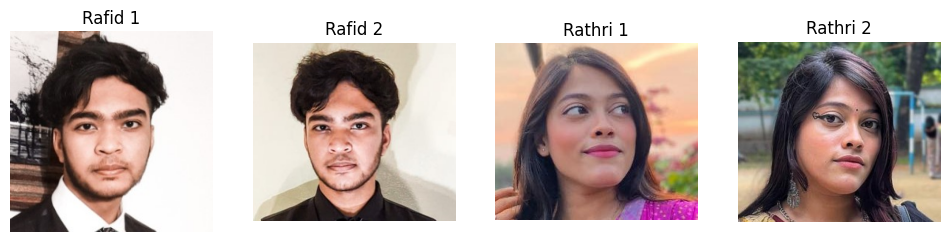

In [60]:
# Load images individually
image1 = Image.open('rafid1.jpg').convert('RGB')
image2 = Image.open('rafid2.jpg').convert('RGB')
image3 = Image.open('rathri1.jpg').convert('RGB')
image4 = Image.open('rathri2.jpg').convert('RGB')

# Display the images using matplotlib
plt.figure(figsize=(12, 6))

# Show Image 1
plt.subplot(1, 4, 1)
plt.imshow(image1)
plt.title('image1')
plt.axis('off')

# Show Image 2
plt.subplot(1, 4, 2)
plt.imshow(image2)
plt.title('image2')
plt.axis('off')

# Show Image 3
plt.subplot(1, 4, 3)
plt.imshow(image3)
plt.title('image3')
plt.axis('off')

# Show Image 4
plt.subplot(1, 4, 4)
plt.imshow(image4)
plt.title('image4')
plt.axis('off')

plt.show()

In [72]:

def predict_similarity(siamese_network, image1, image2, threshold=0.5):

    # Define transformation to resize images and convert to tensors
    transform = transforms.Compose([
        transforms.Resize((100, 100)),  # Resize to 100x100 pixels
        transforms.ToTensor(),  # Convert to tensor (automatically normalizes to [0, 1] range)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])
    
   

    image1 = transform(image1).unsqueeze(0).to(device)  # Add batch dimension and move to device
    image2 = transform(image2).unsqueeze(0).to(device)

    # Ensure the model is in evaluation mode
    siamese_network.eval()

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Pass both images through the Siamese Network
        output1, output2 = siamese_network(image1, image2)
        
        # Calculate the Euclidean distance between the embeddings
        distance =torch.nn.functional.pairwise_distance(output1, output2)
        
        # Check if the distance is less than the threshold
        if distance.item() < threshold:
            return True  # Images are of the same person
        else:
            return False  # Images are of different people


In [129]:
print(predict_similarity(model, image1, image2, threshold=0.5))
print(predict_similarity(model, image3, image4, threshold=0.5))
print(predict_similarity(model, image1, image4, threshold=0.5))

True
True
True
